This notebook illustrates inference with _Swyft_ for **$\Lambda$DDM** cosmology with a simulator of **Stage IV 3x2pt photometric probes**

That is, our observables are the weak-lensing, galaxy clustering and the cross-correlated angular power spectra at different tomographic redshift bins

We focus here on the **2 decaying dark matter parameters**. The main steps are:

- Define the simulator, which uses routines defined in class_interface.py (it requires having _CLASS_ and _DMemu_ installed)

- Load or define a mock observation and a data store

- Rotate the data vector to Cholesky basis, and perform Principal Component Analysis (PCA)

- Define compression network

- Train the network (compression+inference)

- Plot marginal posteriors and compare with results from MCMC chains

In [1]:
# General imports
import swyft  #the version used is 0.4.6.
import torch
import pytorch_lightning as pl

#we use joblib to generate simulations in parallel
from joblib import Parallel, delayed
import psutil

from class_interface import Main

import numpy   as np
from time      import time
from scipy     import stats
from getdist import plots, loadMCSamples #to plot MCMC results

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
rc('text', usetex=True)
rc('font', **{'family': 'serif', 'serif': ['cmr10']})

# Having a GPU makes training much faster, but it's not compulsory
DEVICE = 'gpu' if torch.cuda.is_available() else 'cpu'

True

Set fiducial values for ($\mathrm{log}_{10}(\Gamma \times \mathrm{Gyr})$, $\mathrm{log}_{10}(v_k \times \frac{\mathrm{s}}{\mathrm{km}})$, $H_0$, 100$\omega_b$, $\omega_c$, $n_s$, $\mathrm{ln}(10^{10}A_s)$, $A_{\rm IA}$, $\eta_{\rm IA}$, $b_1$, $b_2$, $b_3$, $b_4$, $b_5$, $b_6$, $b_7$, $b_8$, $b_9$, $b_{10}$)

In [3]:
fiducial = np.array([-3,2,67.,2.2445,0.1206,0.96,3.0568,1.72,-0.41,1.09977,1.22025,1.2724,1.31662,1.35812,1.39982,1.44465,1.4965,1.56525,1.74299])

beta_IA = 0.0 #we neglect dependence of Intrinsic Alignment on the galaxy luminosity function

Load pre-computed inverse of Fisher matrix (see 'Fisher' folder)

In [4]:
N_pars_lcdm = 17 # total number of LCDM+nuisance parameters (not including the 2 DDM parameters)
Finv = np.load('./Fisher/Finv_LCDM.npy')
    
# Obtain 1sigma values of LCDM+nuisance params from Fisher 
sigmas=[]
for i in range(N_pars_lcdm): sigmas.append(np.sqrt(Finv[i,i]))

### Define the simulator class

In [5]:
Nbin_z = 10  # Number of tomographic z-bins
Nbin_ell = 30 # Number of ell-bin edges
N_spectra = Nbin_z*(2*Nbin_z+1) # total number of spectra (210 for 10 z-bins)

lmin = 10
lmax = 2000

class Simulator(swyft.Simulator):
    def __init__(self, zmin = 0.01, kmax = 10., bounds = None):

        super().__init__()
        self.transform_samples = swyft.to_numpy32
        
        # These are the specifications of the experiment
        self.specs = {'fsky': 0.35,
                      'gal_per_arcmin': 30.,
                      'sigma_eps': 0.3,
                      'Nbin_ell': Nbin_ell,
                      'lmin': lmin,
                      'lmax': lmax,
                      'zmin': zmin,
                      'kmax': kmax,           
                      'use_obs': {'GC': True, 'WL': True},
                      'feedback': False, # We don't want to print stuff
                      'ddm':True}  # We want ddm corrections on the non-linear Pk
        
        self.survey = {'luminosity': './Input_files/luminosity_ratio.dat',
                      'nz': './Input_files/nzTabISTF.dat'
                       }
            
        # Initialize interface with CLASS
        self.calculator = Main(self.specs,self.survey)
        # define default prior region
        self.sample_z = swyft.RectBoundSampler(stats.uniform(np.array([-3,2,60,0.8,0.10,0.91,2.8,1.55,-0.45,0.9,1.1,1.15,1.2,1.25,1.3,1.35,1.4,1.4,1.6]), 
                                                             np.array([1.8,1.6,15,2.7,0.04,0.12,0.5,0.34,0.08,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3,0.3])), 
                                                             bounds = bounds) 
 
        #define the keys for the different spectra
        WLcols = ['L{}xL{}'.format(i,j) for i in range(1,Nbin_z+1) for j in range(i,Nbin_z+1)]
        GCcols = ['G{}xG{}'.format(i,j) for i in range(1,Nbin_z+1) for j in range(i,Nbin_z+1)]
        XCcols = ['G{}xL{}'.format(i,j) for i in range(1,Nbin_z+1) for j in range(1,Nbin_z+1)]
        self.all_cols = WLcols+XCcols+GCcols  
        
        # define the ell bins
        ell_lims    = np.logspace(np.log10(lmin),np.log10(lmax),Nbin_ell)
        self.ells   = 0.5*(ell_lims[:-1]+ell_lims[1:])

        # select fiducial parameters
        self.params_fid = {'output':'mPk',
                          'non linear':'halofit',
                          'log10_Gamma':fiducial[0],
                          'log10_vk':fiducial[1],
                          'H0': fiducial[2],
                          'omega_b': fiducial[3]*1e-2,
                          'omega_cdm': fiducial[4],
                          'n_s': fiducial[5],
                          'ln10^{10}A_s': fiducial[6],
                          'tau_reio': 0.05,
                          'N_ur':2.0328,
                          'N_ncdm':1,
                          'm_ncdm': 0.06
                           }
            
        #Update with list of nuisance parameters
        self.params_fid.update({'A_IA': fiducial[7],'eta_IA': fiducial[8],'beta_IA': 0.0,
                                'b_1': fiducial[9], 'b_2': fiducial[10],'b_3': fiducial[11],'b_4': fiducial[12],
                                'b_5': fiducial[13],'b_6': fiducial[14],'b_7': fiducial[15],'b_8': fiducial[16],
                                'b_9': fiducial[17],'b_10':fiducial[18]})
            
        #obtain covariance matrix for fiducial spectra
        self.observables_fid = self.calculator.get_calculations(self.params_fid)
        self.Cls_fid = self.observables_fid.Cls
        self.covmat_fid, self.noisy_Cls_fid = self.calculator.get_noisy_Cls(self.Cls_fid)
        
        # Perform Cholesky decomposition of the covariance matrix
        self.L_fid = {}
        for ind,ell in enumerate(self.ells):
            self.L_fid[str(int(ell))] = torch.linalg.cholesky(torch.tensor(self.covmat_fid[str(int(ell))].values).double())
      
    def get_sample_Cls(self,z):

        #Select cosmo parameters
        self.params = {'output':'mPk',
                      'non linear':'halofit',
                      'log10_Gamma':z[0],
                      'log10_vk':z[1],
                      'H0': z[2],
                      'omega_b': z[3]*1e-2,
                      'omega_cdm': z[4],
                      'n_s': z[5],
                      'ln10^{10}A_s': z[6],
                      'tau_reio': 0.05,
                      'N_ur':2.0328,
                      'N_ncdm':1,
                      'm_ncdm': 0.06
                       }
   
        #Update with list of nuisance parameters
        self.params.update({'A_IA': z[7],'eta_IA': z[8],'beta_IA': 0.0,
                            'b_1': z[9],'b_2': z[10],'b_3': z[11],'b_4': z[12],
                            'b_5': z[13],'b_6': z[14],'b_7': z[15],'b_8': z[16],
                            'b_9': z[17],'b_10':z[18]})
        
        #compute un-noised C_ells spectra
        self.observables = self.calculator.get_calculations(self.params)
        self.Cls = self.observables.Cls    
        self.Cls.pop('ells')
        #Note: self.Cls is a dictionary, but in the simulator we need to have numpy arrays as the output of the graph.nodes            
        vals_Cls = np.array(list(self.Cls.values))
        return vals_Cls.transpose()
    
    def get_sample_noise(self):
        #generate noise realization (using covariance matrix for fiducial cosmology)
        self.noise = self.calculator.get_realization(None,self.covmat_fid,self.all_cols)
        #Note: self.noise is a dictionary, but in the simulator we need to have numpy arrays as the output of the graph.nodes            
        vals_noise = np.array(list(self.noise.values()))
        return vals_noise

    def build(self, graph):
        # define the computational graph of the simulator
        z = graph.node('z', self.sample_z) #draw parameters from the prior
        C_ells = graph.node('C_ells', self.get_sample_Cls, z) #compute un-noised Cls
        noise  = graph.node('noise', self.get_sample_noise) # get the noise, we will add it to the un-noised Cls later

Estimate the bounds of the prior region based on the Fisher results

In [6]:
bounds = []
# for DDM parameters we use entire prior region, 
# (we cannot use estimates from Fisher since DDM posteriors are very non-gaussian)
bounds.append([fiducial[0],fiducial[0]+1.8])
bounds.append([fiducial[1],fiducial[1]+1.6])

for i in range(2,N_pars_lcdm+2):
    #we take slightly wider priors on the rest of parameters to account for potential new degeneracies
    bounds.append([fiducial[i]-6*sigmas[i-2],fiducial[i]+6*sigmas[i-2]]) 
bounds = np.array(bounds)

Create an instance of the simulator class with the correct bounds

In [7]:
generate_sims = False # we can set this flag to False if we already generated the simulations

if generate_sims:    
    sim = Simulator(bounds = bounds)
    shapes, dtypes = sim.get_shapes_and_dtypes()
    print("shapes:", shapes)
    print("dtypes:", dtypes)

Store/load the Cholesky matrix (we will need it later)

In [8]:
if generate_sims:
    Lfid = sim.L_fid
    np.save('./Aux_files/cholesky_LDDM.npy',Lfid, allow_pickle=True)
    
Lfid = np.load('./Aux_files/cholesky_LDDM.npy',allow_pickle=True).item()

Store/load mock observation (we will need it later)

In [9]:
if generate_sims:
    # generate mock data from fiducial model (and save it)
    obs = sim.sample(conditions = {'z': fiducial})
    np.save('./Aux_files/obs_LDDM.npy',obs, allow_pickle=True)
        
obs = np.load('./Aux_files/obs_LDDM.npy',allow_pickle=True).item()

### Create ZarrStore for simulations (or read it if it was already created)

In [10]:
%%time
store = swyft.ZarrStore("./Store_LDDM_3e4sims")

N_sims = 30_000 #number of simulations

# this piece of code allows to generate simulations in parallel 
if generate_sims:
    store.init(N_sims, 64, shapes, dtypes)  
    def simulate_parallel(sim):
        store.simulate(sim,max_sims=64, batch_size = 64)        
    njobs = psutil.cpu_count(logical=True) # njobs = number of available CPUs, the larger the faster
    while store.sims_required > 0:
        Parallel(n_jobs=njobs)(delayed(simulate_parallel)(sim) for _ in range(njobs))
        
store = store.get_sample_store()

Rotate data to the Cholesky basis (in order to decouple the different spectra)

In [11]:
ell_lims    = np.logspace(np.log10(lmin),np.log10(lmax),Nbin_ell)
ells   = 0.5*(ell_lims[:-1]+ell_lims[1:])

Cells_chol = np.zeros((N_sims,N_spectra,Nbin_ell-1))
noise_chol = np.zeros((N_sims,N_spectra,Nbin_ell-1))

for ind,ell in enumerate(ells):
    Linv = np.linalg.inv(Lfid[str(int(ell))]) #inverse of Cholesky matrix
    Cells_chol[...,ind] = np.matmul(Linv, store['C_ells'][...,ind].T).T
    noise_chol[...,ind] = np.matmul(Linv, store['noise'][...,ind].T).T

store_samples = swyft.Samples(z=store['z'], C_ells=Cells_chol,noise=noise_chol) #redefine store with rotated data

### Perform Principal Component Analysis (PCA)

In [12]:
store_PCA = False #set this flag to False if we already did PCA and stored the Vh_proj matrix

if store_PCA:
    # we first flatten all the spectra into a long vector, and take 10^4 samples from the store
    Flatten = torch.nn.Flatten()
    fCells_chol = Flatten(torch.from_numpy(Cells_chol[:10_000])) # shape is (10^4,N_spectra)
    # do singular-value-decomposition
    U, S, Vh = torch.linalg.svd(fCells_chol)
    #obtain the fractional contribution of each eigen-value
    Stot = torch.sum(S)
    Sn = (S/Stot)*100
    if False: #only if we want to plot the eigenvalues (from largest to lowest)
        plt.loglog(Sn)
        plt.ylabel(r'Eigenvalue $\lambda_i$ contribution ($\%$)',fontsize=14)
        plt.xlabel(r'Eigenvalue index $i$',fontsize=14)
        plt.ylim([1e-6,100.1])
        plt.xlim([0,6090])
    #store the matrix Vh, but only keeping the terms whose eigenvalues contribute more than 0.01%
    ind = Sn > 0.01
    Vh_proj = Vh[ind]
    np.save('./Aux_files/SVD_LDDM.npy',Vh_proj, allow_pickle=True)

#load the matrix Vh
Vh_proj = np.load('./Aux_files/SVD_LDDM.npy',allow_pickle=True)
Vh_proj = torch.from_numpy(Vh_proj).cuda().double()
lenV = len(Vh_proj) #number of PCA components

### Define the network architecture

In [32]:
# Define network here
class Network(swyft.AdamWReduceLROnPlateau,swyft.SwyftModule):
    def __init__(self):
        super().__init__()
        self.learning_rate = 1e-3
        self.batch_size = 256 
        self.num_params_show = 2 # number of parameters of interest, obviously cannot be larger than N_pars
        self.num_feat_param = 2 # number of features per parameter of interest (2 seem to work well)
        self.marginals  = self.get_marginals(self.num_params_show) 
        self.flatten = torch.nn.Flatten() 
        self.norm =  swyft.networks.OnlineStandardizingLayer(torch.Size([lenV]), epsilon=1e-50)
        
        #compression network, here one could play with number of layers and neurons
        self.sequential = torch.nn.Sequential(
            torch.nn.LazyLinear(256), 
            torch.nn.ReLU(),
            torch.nn.LazyLinear(self.num_params_show*self.num_feat_param),
            torch.nn.LazyBatchNorm1d()
        )
        
        #pre-defined MLP to get 1-dim marginals
        self.logratios1 = swyft.LogRatioEstimator_1dim(num_features = self.num_feat_param, 
                                                       num_params = self.num_params_show, varnames = 'z', 
                                                       num_blocks = 4, dropout = 0.1)
        #pre-defined MLP to get 2-dim marginals
        self.logratios2 = swyft.LogRatioEstimator_Ndim(num_features = 2*self.num_feat_param,
                                                       marginals = self.marginals, varnames = 'z',
                                                       num_blocks = 4, dropout = 0.1)

    @staticmethod
    def get_marginals(n_params): #get all possible marginal combinations given number of parameters
        marginals = []
        for i in range(n_params):
            for j in range(n_params):
                if j>i: marginals.append((i, j))
        return tuple(marginals)
    
    def forward(self, A, B):
        
        C_ells_noisy_chol = A['C_ells']+A['noise']   #add noise to the spectra
        fC_ells_noisy_chol = self.flatten(C_ells_noisy_chol) #flatten all spectra into a large vector   
        
        s = (Vh_proj@fC_ells_noisy_chol.T).T #project to PCA basis
        s = self.norm(s)  #normalization
        s = self.sequential(s)  #linear compression
        
        z = B['z'][...,:self.num_params_show] #select only params of interest
        
        # Use num_feat_param per 1-dim marginal, s1 has shape (batch, num_params_show, num_feat_param)
        s1 = s.reshape(-1, self.num_params_show, self.num_feat_param)  
        # Use num_feat_param+num_feat_param per 2-dim marginal, s2 has shape (batch, num_marginals, 2*num_feat_param)
        s2 = torch.stack([torch.cat([s1[:, i, :], s1[:, j, :]], dim = -1) for i, j in self.marginals], dim = 1)  
        logratios1 = self.logratios1(s1, z)
        logratios2 = self.logratios2(s2, z)
        return logratios1, logratios2

This function allows to resample the noise on the fly, it helps a lot with the training

In [33]:
def resampler(x): # we mix the noise of different spectra across different realizations
                  # (notice that we can do this because we rotated to Cholesky basis, where spectra are independent)
    i = np.random.randint(N_sims, size = (N_spectra,)) 
    noise = np.array([store_samples['noise'][j][k] for k, j in enumerate(i)]) 
    x['noise'] = noise
    return x

### Train the network

In [34]:
%%time
# Perform inference
network = Network()
dm = swyft.SwyftDataModule(store_samples, num_workers = 3, 
                           batch_size = network.batch_size,
                           val_fraction = 0.2, #we use 20% of the samples for validation
                           on_after_load_sample=resampler) #do noise resampling

trainer = swyft.SwyftTrainer(accelerator = DEVICE, devices=1, 
                             max_epochs = -1, precision = 64)

trainer.fit(network, dm)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


To get consistent results, we also need to rotate the mock observation to the Cholesky basis

In [35]:
oCells_chol = np.zeros((N_spectra,Nbin_ell-1))
onoise_chol = np.zeros((N_spectra,Nbin_ell-1))

for ind,ell in enumerate(ells):
    Linv = np.linalg.inv(Lfid[str(int(ell))])
    oCells_chol[...,ind] = np.matmul(Linv, obs['C_ells'][...,ind].T).T
    onoise_chol[...,ind] = np.matmul(Linv, obs['noise'][...,ind].T).T
    
obs_p = swyft.Sample(dict(C_ells=oCells_chol, noise=0.*onoise_chol))  # we choose to work with a noiseless observation

We quickly evaluate the trained network with the mock observation and many parameter samples ($2\times 10^6$) drawn from the prior

In [36]:
prior_samples = swyft.Samples(z = stats.uniform([-3,2], 
                                                [1.8,1.6]).rvs(size=(2_000_000,2))) 
# note: we choose a very large number of prior samples to get smooth posteriors, but evaluation is still very fast

predictions = trainer.infer(network, obs_p, prior_samples)

The following callbacks returned in `LightningModule.configure_callbacks` will override existing callbacks passed to Trainer: ModelCheckpoint
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

We post-process the MCMC chains using getdist

In [37]:
chains = {'varnuis_bbin': {'path': './MontePython/chains/3x2pt_LDDM/2024-03-11_2000000_','burn_in': 0.3,'Nchains': 18}}

def analyze_chain(name,chain):
    sample = loadMCSamples(chain['path'], settings={'ignore_rows': chain['burn_in']})
    sample.setRanges({'log10_Gamma':(-3,-1.2)})
    sample.setRanges({'log10_vk':(2,3.6)})
    chain['sample'] = sample
    return chain

#list of parameters that we want to plot
plot_pars = ['log10_Gamma','log10_vk']

chains = {name: analyze_chain(name,chain) for name,chain in chains.items()}
LDDM_3x2pt = [chain['sample'] for chain in chains.values()]

#create instance of single_plotter, just to be able to plot posteriors from the MCMC later
g = plots.get_single_plotter(width_inch=8) 
g.settings.axes_labelsize=20

<Figure size 800x600 with 0 Axes>

### Plot marginal posteriors and compare Swyft results with MCMC

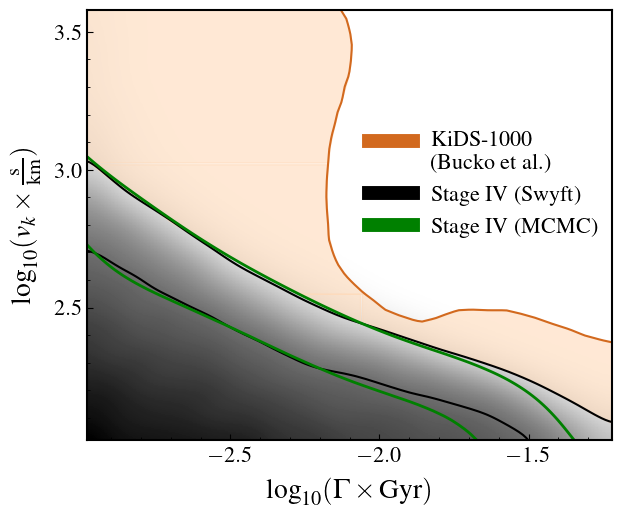

In [38]:
%matplotlib inline 
from scipy.interpolate import interp1d

show_MCMC = True #Flag to decide whether we want to show the MCMC posteriors
color_mcmc='green'
color_swyft='black'
color_kids='peachpuff'

#read file with KiDS-1000 bounds from https://arxiv.org/abs/2307.03222 
l10_Gamma_kids,l10_vk_kids =np.loadtxt('./Aux_files/bounds_DDM_KiDS.txt',unpack=True,skiprows=1)
l10_Gamma_s4,l10_vk_s4 =np.loadtxt('./Aux_files/bounds_DDM_stage4.txt',unpack=True)

#some interpolations to help with plotting
fl10_vk_s4 = interp1d(l10_Gamma_s4,l10_vk_s4)
fl10_Gamma_s4 = interp1d(l10_vk_s4,l10_Gamma_s4)
fl10_vk_kids = interp1d(l10_Gamma_kids,l10_vk_kids)
fl10_Gamma_kids = interp1d(l10_vk_kids,l10_Gamma_kids)

# pair plot with swyft predictions
swyft.plot_pair(predictions, ('z[0]', 'z[1]'),figsize=(6,5), 
                             bins = 150, smooth = 4.0) #we play with number of bins and smoothing to make posteriors look smoother

fontsize=16
labelpad=10
plt.xlabel(r'$\mathrm{log}_{10}(\Gamma \times \mathrm{Gyr})$',fontsize = fontsize,labelpad=labelpad)
plt.ylabel(r'$\mathrm{log}_{10}(v_k \times \frac{\mathrm{s}}{\mathrm{km}})$',fontsize = fontsize,labelpad=labelpad)


epsilon=0.02 # we slightly cut the axes just for aesthetics

if show_MCMC: # add 2D posterior from MCMC
    g.plot_2d(LDDM_3x2pt, plot_pars[0], plot_pars[1],ax = plt.gca(), colors=[color_mcmc],
              lws=[2.0],alphas=[1.0],lims = [bounds[0,0]+epsilon,bounds[0,1]-epsilon, bounds[1,0]+epsilon,bounds[1,1]-epsilon])
    

# ugly routine to plot current KiDS-1000 bounds and corresponding contour (this can surely be optimized!)
plt.plot(l10_Gamma_kids, l10_vk_kids, '-', color='chocolate', linewidth=1.5)
alpha=0.6
x1 = l10_Gamma_kids[65:121]
plt.fill_between(x1,fl10_vk_s4(x1)+0.01,fl10_vk_kids(x1),zorder=1,color=color_kids,alpha=alpha,interpolate=True)
x2=np.linspace(3.026,3.59,10)
plt.fill_betweenx(x2,-3,fl10_Gamma_kids(x2),zorder=1,color=color_kids,alpha=alpha,interpolate=True)
x3=np.linspace(2.55,3.02,10)
plt.fill_betweenx(x3,fl10_Gamma_s4(x3),fl10_Gamma_kids(x3),zorder=1,color=color_kids,alpha=alpha,interpolate=True)
x4=np.linspace(2.45,2.55,10)
plt.fill_betweenx(x4,fl10_Gamma_s4(x4),-2.065,zorder=1,color=color_kids,alpha=alpha,interpolate=True)


#play with tick settings        
fontsize_tick = 16
plt.gca().minorticks_on()
plt.gca().tick_params(axis='both', which='minor',direction="in", labelsize=fontsize_tick,size=2)
plt.gca().tick_params(axis='both', which='major',direction="in", labelsize=fontsize_tick,size=4)

#change appearance of axes    
[x.set_linewidth(1.5) for x in plt.gca().spines.values()]

# add legend
labels=['\n KiDS-1000 \n (Bucko et al.)']
colors=['chocolate']
labels.append(r'Stage IV (Swyft)')
colors.append(color_swyft)
if show_MCMC:
    labels.append(r'Stage IV (MCMC)')
    colors.append(color_mcmc)
lines = [Line2D([0], [0], color=colors[i], linewidth=10, linestyle='-') for i in range(3)]
plt.legend(lines, labels,loc=(0.52,0.45),fontsize=16,frameon=False)

# save figure
plt.savefig('Swyft_vs_MCMC_LDDM.pdf',bbox_inches='tight')